# Using BERT to Identify the Narrators (Binary Classification)

While binary classification [reliably identifies one of the narrators](2_BERT_binary_classification_bill.ipynb) (Bill Hardy), multiclass classification [performs very poorly](3_BERT_multiclass_classification_WIP.ipynb).

There is some paradox. To investigate it, we can compare the outputs of binary classification applied to each narrator.

In [1]:
%%capture

# make logs less verbose
import os

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

# suppress UnparsedFlagAccessError warning
import sys
from absl import flags

sys.argv = ["preserve_unused_tokens=False"]
flags.FLAGS(sys.argv)

# suppress warnings
# (after having ensured they did not impact the analysis)
import warnings

warnings.filterwarnings("ignore")

## Process data

In [2]:
import pandas as pd

df = pd.read_json("./data/jawbone.json")

Augment the data with a column per narrator, `1` if a page belongs to a given narrator, `0` otherwise.

In [3]:
import json

f = open("./data/unofficial_solution.json")
possible_solutions = json.load(f)
f.close()


def get_narrator(id):
    for key, ids in possible_solutions.items():
        if id in ids:
            return key
    return None


df = df.astype({"text": "string"})

# create one boolean column per narrator
dummies = pd.get_dummies(df["page"].apply(lambda x: get_narrator(x)).str.get_dummies())

df = pd.concat([df, dummies], axis=1)
df = df.astype({col: "int" for col in dummies.columns})
df

,page,text,Bill Hardy,Clement DeAth,Henry (dog),Jasmine Gay,John Walker,May Doncaster,Oscar Mills,Sir Paul Trinder
0,1,I sit down alone at the appointed table and ta...,1,0,0,0,0,0,0,0
1,2,I plunged for the last time. The few remaining...,0,0,0,0,0,0,1,0
2,3,"At my meeting with Clement yesterday, he had b...",0,0,0,0,1,0,0,0
3,4,And I really think I would have preferred the ...,1,0,0,0,0,0,0,0
4,5,I hated my eye for being caught by what didn’t...,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...
95,96,Now I think I will try a cup of what they inso...,1,0,0,0,0,0,0,0
96,97,To have slept and to wake right up surrounded ...,0,0,0,0,1,0,0,0
97,98,He stood and looked down at me; but I was not ...,0,0,0,0,0,0,0,1
98,99,"And she wore a mauve love-knot on her breast, ...",0,0,1,0,0,0,0,0


---

The approach initially used for Bill is transposed to all narrators.

In [4]:
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import logging

logging.set_verbosity_error()  # suppress untrained weight error (unconsequential)

# use BERT base uncased model
# https://huggingface.co/bert-base-uncased
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
bert_model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", num_labels=1
)

In [5]:
import torch

# hyperparameters

num_epochs = 20
learning_rate = 2e-5
batch_size = 4
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

The book is sampled for training and testing in the following proportion:

* **4 pages beloging to a given narrator**, and
* **25 pages from other narrators**

The size of the test dataset is 20% of the sampled subset of the book.

In [6]:
from sklearn.model_selection import train_test_split


def get_datasets(df, narrator):
    # sample 40% of the narrator pages/sentences and 30% of all pages/sentences
    df_is_narrator = df[df[narrator] == 1].sample(frac=0.4)
    df_not_narrator = df[df[narrator] == 0].sample(frac=0.3)

    df_sampled = pd.concat([df_is_narrator, df_not_narrator], axis=0)

    # split datasets
    return train_test_split(
        df_sampled["text"].values,
        df_sampled[narrator].values,
        test_size=None,
        random_state=42,
    )

In [7]:
from torch.utils.data import DataLoader, Dataset


# tokenize and prepare the input data
class TokenizedData(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = float(self.labels[idx])
        inputs = self.tokenizer(
            text,
            truncation=True,
            padding="max_length",
            max_length=self.max_len,
            return_tensors="pt",
        )
        return {
            "input_ids": inputs["input_ids"].flatten(),
            "attention_mask": inputs["attention_mask"].flatten(),
            "label": torch.tensor(label, dtype=torch.float32),
        }

In [8]:
from transformers import AdamW
import copy


def train(df, narrator):
    train_texts, _, train_labels, _ = get_datasets(df, narrator)

    train_dataloader = DataLoader(
        TokenizedData(train_texts, train_labels, tokenizer, max_len=256),
        batch_size=batch_size,
        shuffle=False,
    )

    print(f"Train dataset size: {train_texts.shape[0]}")

    model = copy.deepcopy(bert_model)
    criterion = torch.nn.BCEWithLogitsLoss()
    optimizer = AdamW(model.parameters(), lr=learning_rate)

    model.to(device)

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0.0

        for batch in train_dataloader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["label"].squeeze().to(device)

            if input_ids.numel() < batch_size or labels.numel() < batch_size:
                continue

            optimizer.zero_grad()
            outputs = model(input_ids, attention_mask=attention_mask)

            loss = criterion(outputs.logits.flatten(), labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_loss = total_loss / len(train_dataloader)
        print(f"{epoch + 1}/{num_epochs} — loss: {avg_loss:.4f}")

    return model

## Prediction

In [9]:
from sklearn.metrics import accuracy_score


def eval(model, texts):
    model.eval()

    inputs = tokenizer(
        [text for text in texts],
        return_tensors="pt",
        truncation=True,
        padding=True,
    )
    input_ids = inputs["input_ids"].to(device)
    attention_mask = inputs["attention_mask"].to(device)

    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)

    probabilities = torch.sigmoid(outputs.logits).cpu().numpy()
    predicted_labels = (probabilities > 0.5).astype(int)

    return predicted_labels

In [10]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


def generate_confusion_matrix(model, df, predicted_labels, narrator):
    cm = confusion_matrix(df[narrator].values, predicted_labels)
    disp = ConfusionMatrixDisplay(
        confusion_matrix=cm, display_labels=["Someone else", narrator]
    )

    plt.figure(figsize=(8, 6))
    disp.plot(cmap="Blues")

    plt.show()

In [11]:
import matplotlib.patches as mpatches


def represent_pages(df, narrator):
    cols, rows = 10, 10

    expected_pages = [
        page - 1 for page in df[df[narrator] == 1]["page"].values.tolist()
    ]
    predicted_pages = [
        index for index, value in enumerate(predicted_labels.flatten()) if value == 1
    ]

    fig, axs = plt.subplots(rows, cols, figsize=(cols, rows), tight_layout=True)

    for i, ax in enumerate(axs.ravel()):
        ax.set_xticks([])
        ax.set_yticks([])
        ax.add_patch(
            plt.Rectangle(
                (0, 0), 1, 1, fill=True, edgecolor="#000000", facecolor="#FFFFFF"
            )
        )
        row, col = divmod(i, cols)
        ax.text(
            0.5, 0.95, str(i + 1), ha="center", va="top", color="#000000", fontsize=8
        )

    common_indices = set.intersection(set(expected_pages), set(predicted_pages))

    for index in expected_pages + predicted_pages:
        row, col = divmod(index, cols)

        if index in common_indices:
            # pages adequately predicted
            axs[row, col].patches[0].set_facecolor("#FFE871")
            axs[row, col].text(
                0.5, 0.5, "✔", ha="center", va="center", color="green", fontsize=12
            )
        elif index in expected_pages:
            # pages erroneously not predicted
            axs[row, col].patches[0].set_facecolor("#A6B7DE")
            axs[row, col].text(
                0.5, 0.5, "✘", ha="center", va="center", color="red", fontsize=12
            )
        else:
            # pages erroneously predicted
            axs[row, col].patches[0].set_facecolor("#DEA6BA")
            axs[row, col].text(
                0.5, 0.5, "✘", ha="center", va="center", color="red", fontsize=12
            )

    plt.legend(
        handles=[
            mpatches.Patch(color="#FFE871", label="Correct Prediction"),
            mpatches.Patch(color="#A6B7DE", label="Missed Prediction"),
            mpatches.Patch(color="#DEA6BA", label="Incorrect Prediction"),
        ],
        loc="upper center",
        bbox_to_anchor=(0.5, -0.15),
        fancybox=True,
        ncol=3,
    )

    fig.set_size_inches(12, 10)
    plt.subplots_adjust(
        top=0.9, bottom=0.2, left=0.1, right=0.9, hspace=0.1, wspace=0.1
    )

    plt.show()

----
# Narrators

## Oscar Mills
<img src="https://glthr.com/cj/characters/oscar-min.jpg" alt="drawing" width="400"/>

In [12]:
narrator = "Oscar Mills"
model = train(df, narrator)

Train dataset size: 23
1/20 — loss: 0.5142
2/20 — loss: 0.4621
3/20 — loss: 0.4328
4/20 — loss: 0.3770
5/20 — loss: 0.3162
6/20 — loss: 0.2595
7/20 — loss: 0.2370
8/20 — loss: 0.2151
9/20 — loss: 0.1771
10/20 — loss: 0.1727
11/20 — loss: 0.1377
12/20 — loss: 0.1451
13/20 — loss: 0.1275
14/20 — loss: 0.1193
15/20 — loss: 0.0951
16/20 — loss: 0.0817
17/20 — loss: 0.0715
18/20 — loss: 0.0632
19/20 — loss: 0.0530
20/20 — loss: 0.0435


<Figure size 800x600 with 0 Axes>

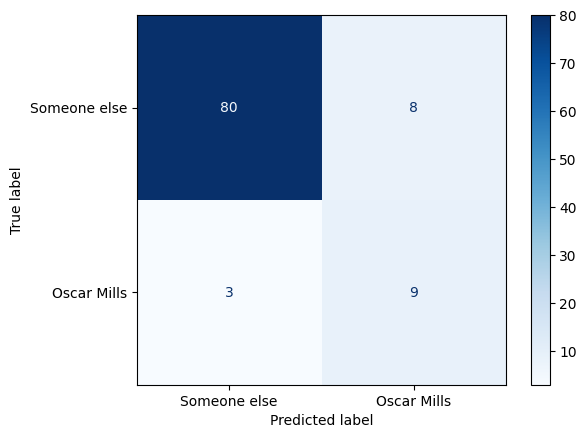

In [13]:
predicted_labels = eval(model, df.text.values)
generate_confusion_matrix(model, df, predicted_labels, narrator)

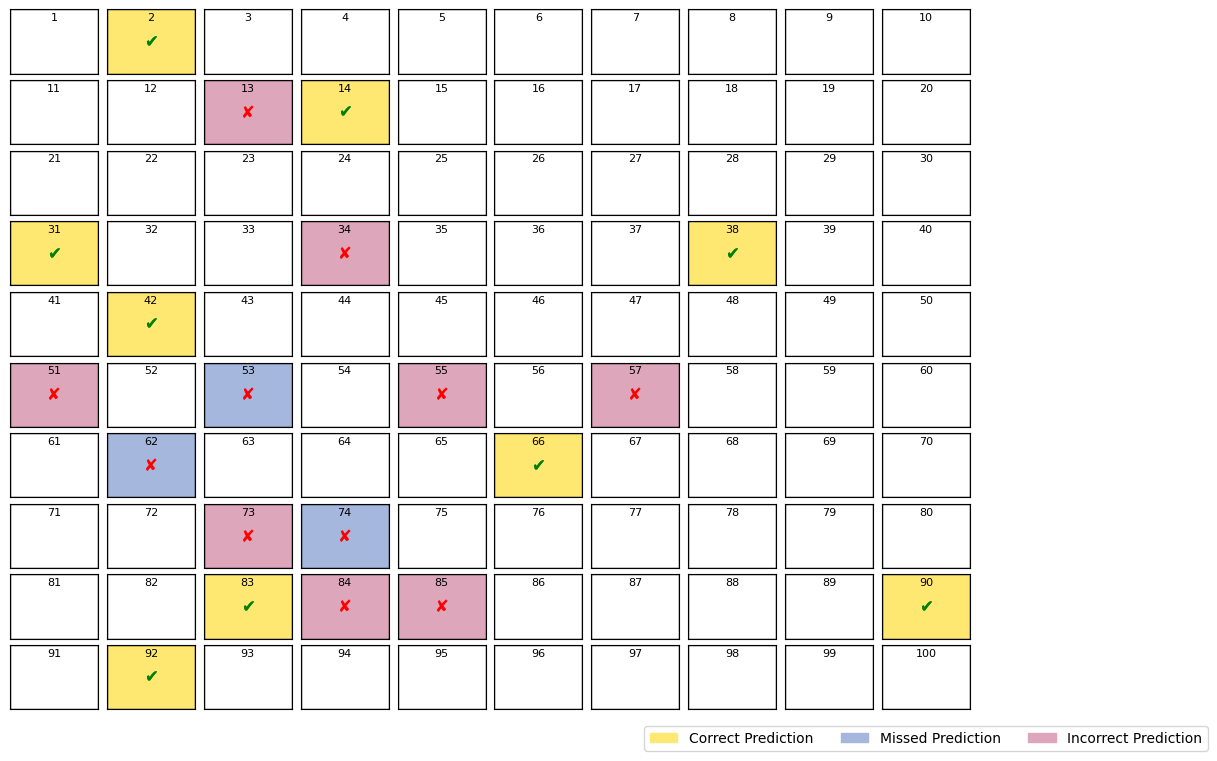

In [14]:
represent_pages(df, narrator)

## May Doncaster
<img src="https://glthr.com/cj/characters/may-min.jpg" alt="drawing" width="400"/>

In [15]:
narrator = "May Doncaster"
model = train(df, narrator)

Train dataset size: 23
1/20 — loss: 0.5245
2/20 — loss: 0.4541
3/20 — loss: 0.4159
4/20 — loss: 0.3598
5/20 — loss: 0.2769
6/20 — loss: 0.2505
7/20 — loss: 0.1858
8/20 — loss: 0.1506
9/20 — loss: 0.1467
10/20 — loss: 0.1167
11/20 — loss: 0.0975
12/20 — loss: 0.0920
13/20 — loss: 0.0812
14/20 — loss: 0.0685
15/20 — loss: 0.0642
16/20 — loss: 0.0561
17/20 — loss: 0.0486
18/20 — loss: 0.0405
19/20 — loss: 0.0375
20/20 — loss: 0.0290


<Figure size 800x600 with 0 Axes>

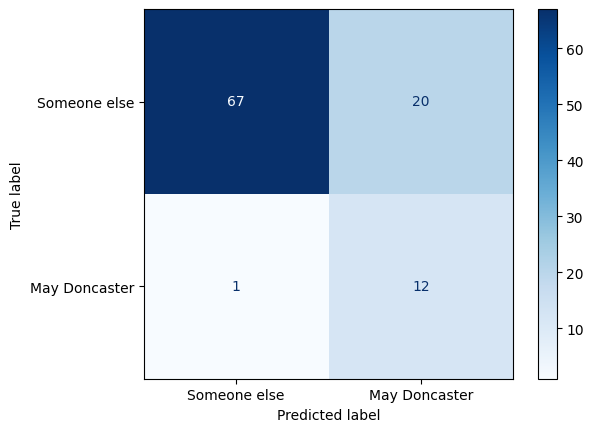

In [16]:
predicted_labels = eval(model, df.text.values)
generate_confusion_matrix(model, df, predicted_labels, narrator)

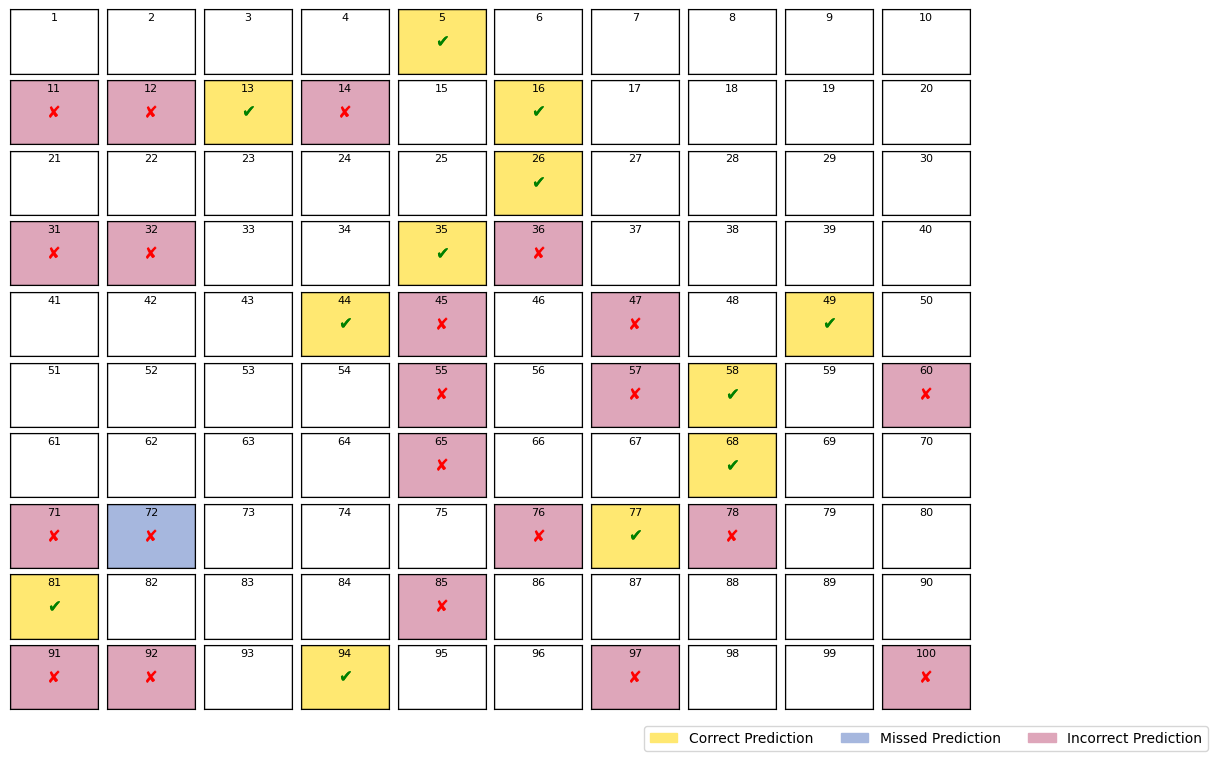

In [17]:
represent_pages(df, narrator)

## Sir Paul Trinder
<img src="https://glthr.com/cj/characters/paul-min.jpg" alt="drawing" width="400"/>

In [18]:
narrator = "Sir Paul Trinder"
model = train(df, narrator)

Train dataset size: 23
1/20 — loss: 0.5315
2/20 — loss: 0.4645
3/20 — loss: 0.4313
4/20 — loss: 0.3970
5/20 — loss: 0.3517
6/20 — loss: 0.3220
7/20 — loss: 0.2824
8/20 — loss: 0.2140
9/20 — loss: 0.2102
10/20 — loss: 0.1809
11/20 — loss: 0.1512
12/20 — loss: 0.1320
13/20 — loss: 0.1107
14/20 — loss: 0.0925
15/20 — loss: 0.0699
16/20 — loss: 0.0538
17/20 — loss: 0.0379
18/20 — loss: 0.0276
19/20 — loss: 0.0211
20/20 — loss: 0.0168


<Figure size 800x600 with 0 Axes>

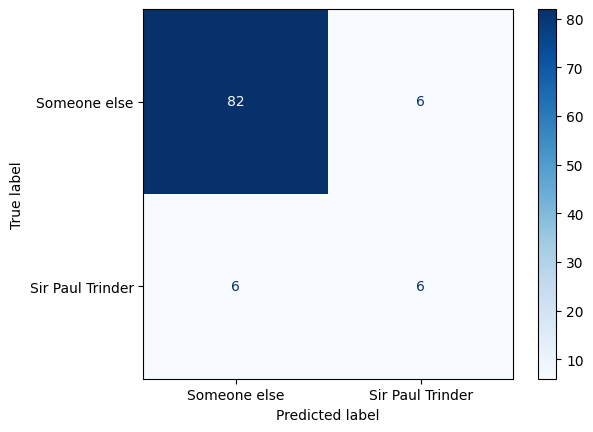

In [19]:
predicted_labels = eval(model, df.text.values)
generate_confusion_matrix(model, df, predicted_labels, narrator)

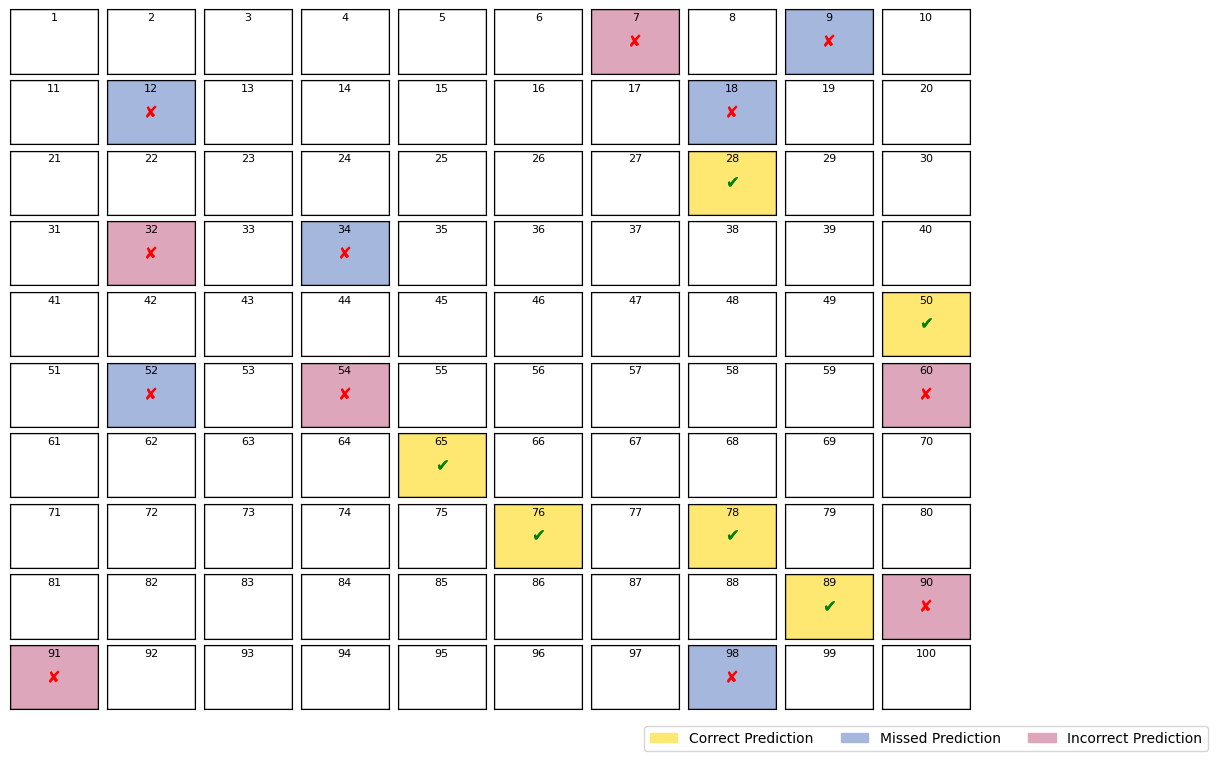

In [20]:
represent_pages(df, narrator)

## Clement DeAth
<img src="https://glthr.com/cj/characters/clement-min.jpg" alt="drawing" width="400"/>

In [21]:
narrator = "Clement DeAth"
model = train(df, narrator)

Train dataset size: 23
1/20 — loss: 0.5070
2/20 — loss: 0.4752
3/20 — loss: 0.4401
4/20 — loss: 0.4026
5/20 — loss: 0.3302
6/20 — loss: 0.2817
7/20 — loss: 0.2864
8/20 — loss: 0.1967
9/20 — loss: 0.2125
10/20 — loss: 0.1732
11/20 — loss: 0.1584
12/20 — loss: 0.1504
13/20 — loss: 0.1226
14/20 — loss: 0.1180
15/20 — loss: 0.1075
16/20 — loss: 0.0806
17/20 — loss: 0.0672
18/20 — loss: 0.0536
19/20 — loss: 0.0402
20/20 — loss: 0.0331


<Figure size 800x600 with 0 Axes>

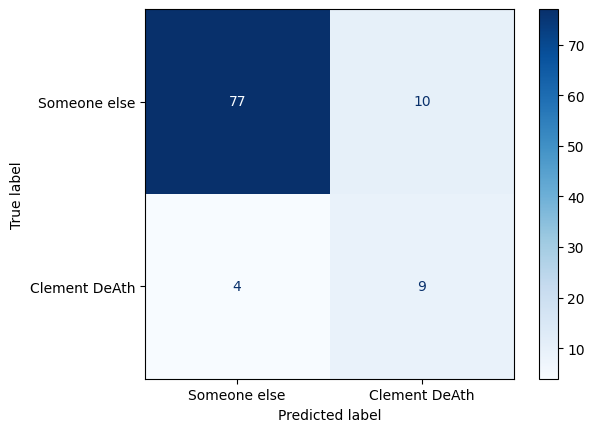

In [22]:
predicted_labels = eval(model, df.text.values)
generate_confusion_matrix(model, df, predicted_labels, narrator)

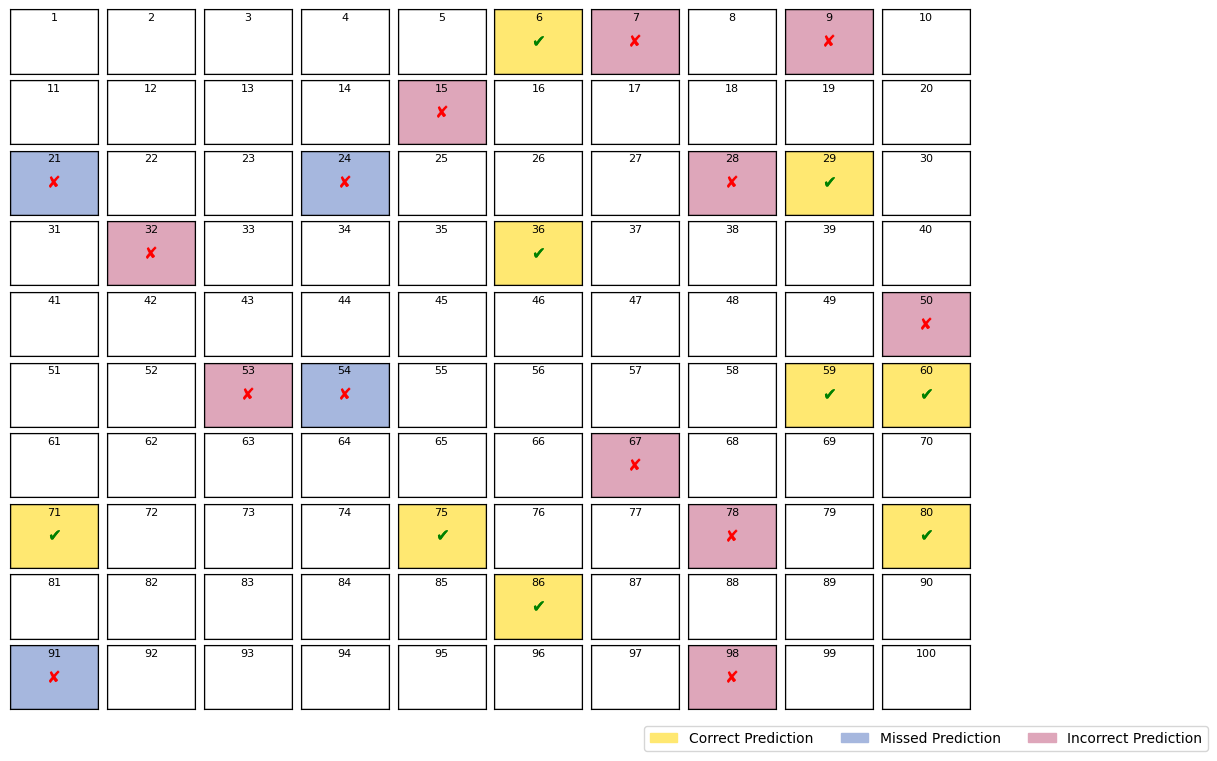

In [23]:
represent_pages(df, narrator)

## Bill Hardy
<img src="https://glthr.com/cj/characters/bill-min.jpg" alt="drawing" width="400"/>

In [24]:
narrator = "Bill Hardy"
model = train(df, narrator)

Train dataset size: 23
1/20 — loss: 0.5144
2/20 — loss: 0.4723
3/20 — loss: 0.3983
4/20 — loss: 0.3761
5/20 — loss: 0.2848
6/20 — loss: 0.2217
7/20 — loss: 0.1640
8/20 — loss: 0.1297
9/20 — loss: 0.1080
10/20 — loss: 0.0847
11/20 — loss: 0.0669
12/20 — loss: 0.0456
13/20 — loss: 0.0362
14/20 — loss: 0.0248
15/20 — loss: 0.0208
16/20 — loss: 0.0184
17/20 — loss: 0.0145
18/20 — loss: 0.0126
19/20 — loss: 0.0118
20/20 — loss: 0.0099


<Figure size 800x600 with 0 Axes>

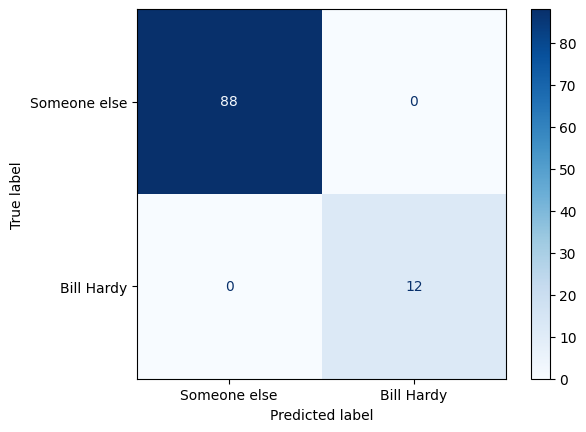

In [25]:
predicted_labels = eval(model, df.text.values)
generate_confusion_matrix(model, df, predicted_labels, narrator)

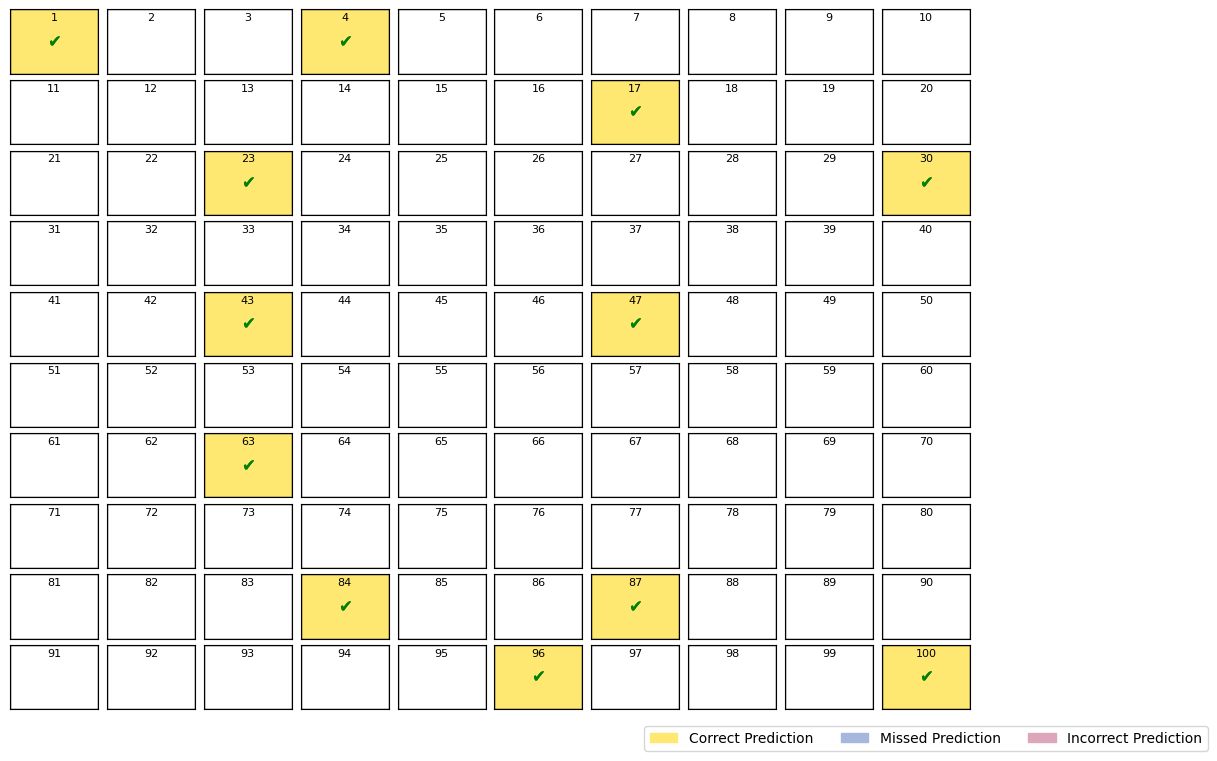

In [26]:
represent_pages(df, narrator)

## Jasmine Gay
<img src="https://glthr.com/cj/characters/jasmine-min.jpg" alt="drawing" width="400"/>

In [27]:
narrator = "Jasmine Gay"
model = train(df, narrator)

Train dataset size: 23
1/20 — loss: 0.5181
2/20 — loss: 0.4598
3/20 — loss: 0.4421
4/20 — loss: 0.4122
5/20 — loss: 0.3610
6/20 — loss: 0.3202
7/20 — loss: 0.2593
8/20 — loss: 0.2175
9/20 — loss: 0.1939
10/20 — loss: 0.1769
11/20 — loss: 0.1459
12/20 — loss: 0.1349
13/20 — loss: 0.1012
14/20 — loss: 0.0857
15/20 — loss: 0.0787
16/20 — loss: 0.0694
17/20 — loss: 0.0568
18/20 — loss: 0.0528
19/20 — loss: 0.0415
20/20 — loss: 0.0352


<Figure size 800x600 with 0 Axes>

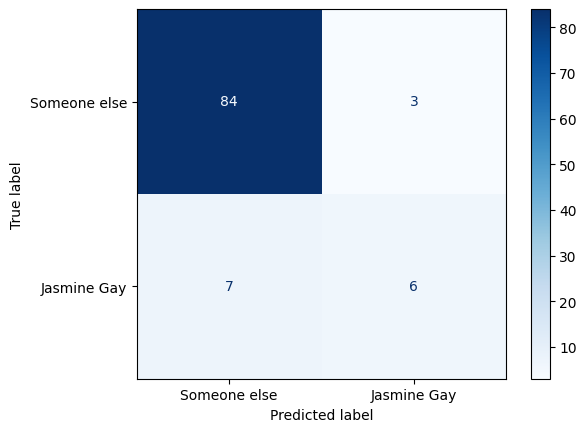

In [28]:
predicted_labels = eval(model, df.text.values)
generate_confusion_matrix(model, df, predicted_labels, narrator)

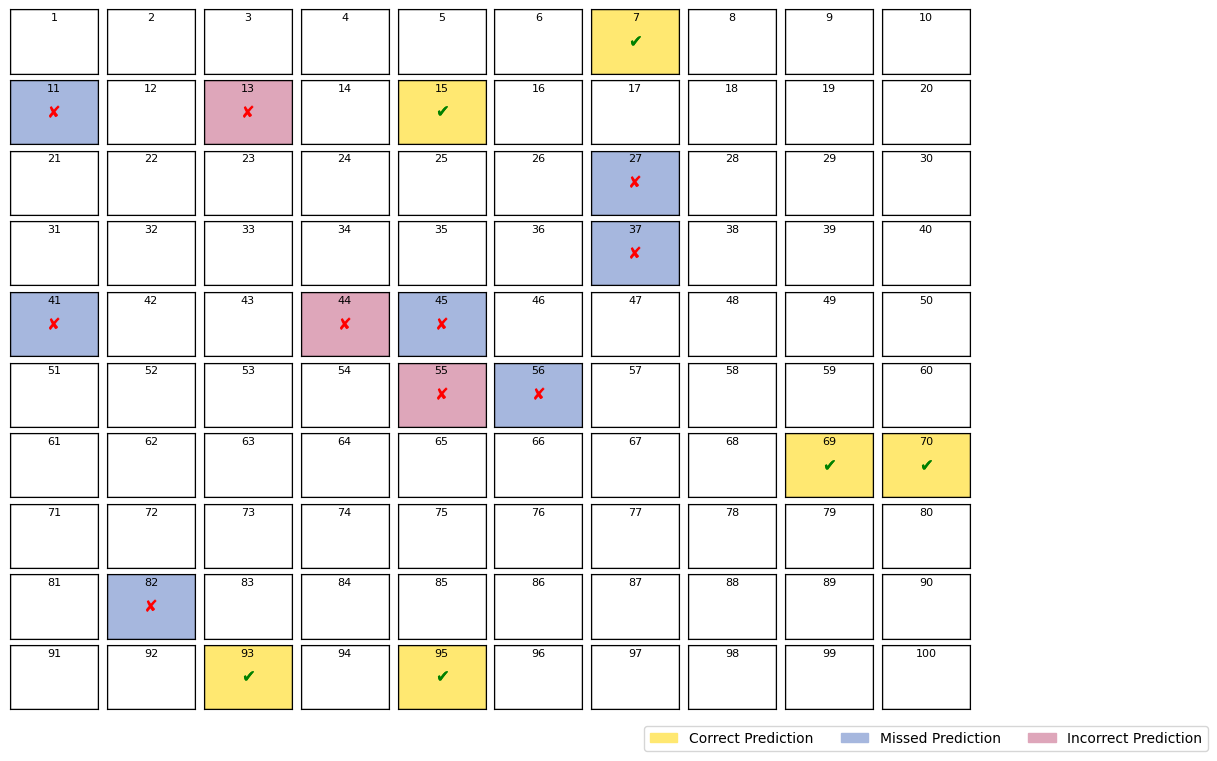

In [29]:
represent_pages(df, narrator)

## John Walker
<img src="https://glthr.com/cj/characters/john-min.jpg" alt="drawing" width="400"/>

In [30]:
narrator = "John Walker"
model = train(df, narrator)

Train dataset size: 23
1/20 — loss: 0.5141
2/20 — loss: 0.4624
3/20 — loss: 0.4140
4/20 — loss: 0.3954
5/20 — loss: 0.3528
6/20 — loss: 0.3061
7/20 — loss: 0.2659
8/20 — loss: 0.2138
9/20 — loss: 0.1904
10/20 — loss: 0.1505
11/20 — loss: 0.1478
12/20 — loss: 0.1272
13/20 — loss: 0.1153
14/20 — loss: 0.0901
15/20 — loss: 0.0630
16/20 — loss: 0.0407
17/20 — loss: 0.0345
18/20 — loss: 0.0250
19/20 — loss: 0.0231
20/20 — loss: 0.0180


<Figure size 800x600 with 0 Axes>

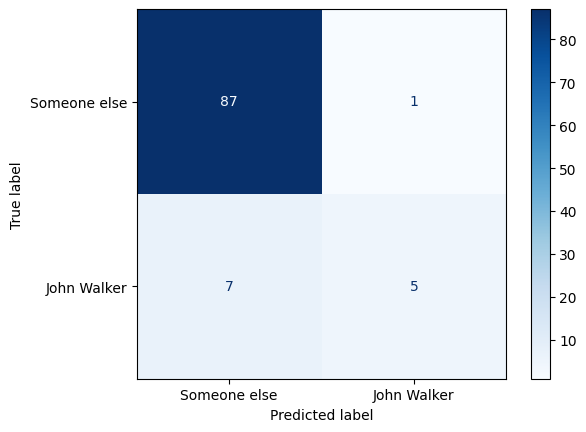

In [31]:
predicted_labels = eval(model, df.text.values)
generate_confusion_matrix(model, df, predicted_labels, narrator)

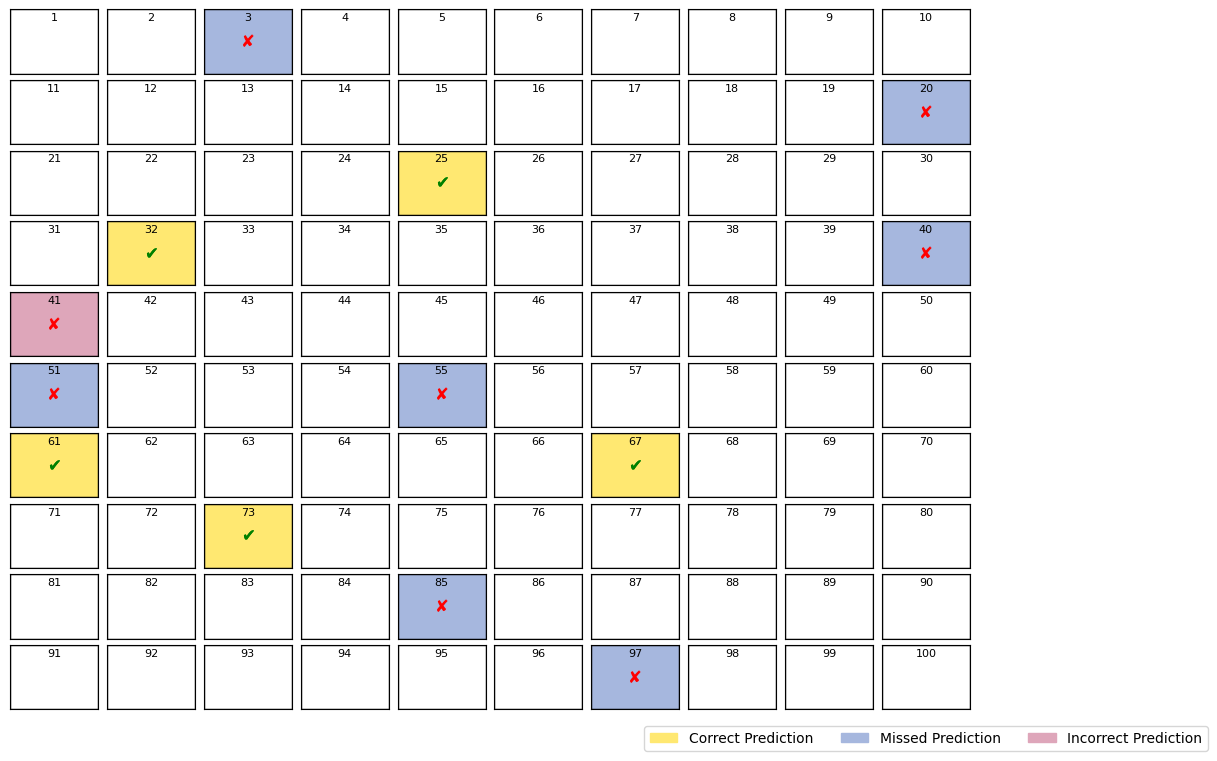

In [32]:
represent_pages(df, narrator)

## Henry (dog)
<img src="https://glthr.com/cj/characters/henry-min.jpg" alt="drawing" width="400"/>

In [33]:
narrator = "Henry (dog)"
model = train(df, narrator)

Train dataset size: 23
1/20 — loss: 0.5059
2/20 — loss: 0.4574
3/20 — loss: 0.4022
4/20 — loss: 0.3256
5/20 — loss: 0.2815
6/20 — loss: 0.2209
7/20 — loss: 0.1872
8/20 — loss: 0.1383
9/20 — loss: 0.1112
10/20 — loss: 0.0969
11/20 — loss: 0.0727
12/20 — loss: 0.0626
13/20 — loss: 0.0524
14/20 — loss: 0.0416
15/20 — loss: 0.0339
16/20 — loss: 0.0250
17/20 — loss: 0.0224
18/20 — loss: 0.0194
19/20 — loss: 0.0167
20/20 — loss: 0.0146


<Figure size 800x600 with 0 Axes>

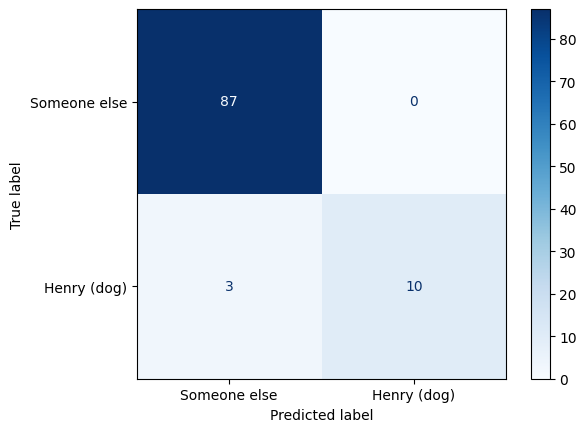

In [34]:
predicted_labels = eval(model, df.text.values)
generate_confusion_matrix(model, df, predicted_labels, narrator)

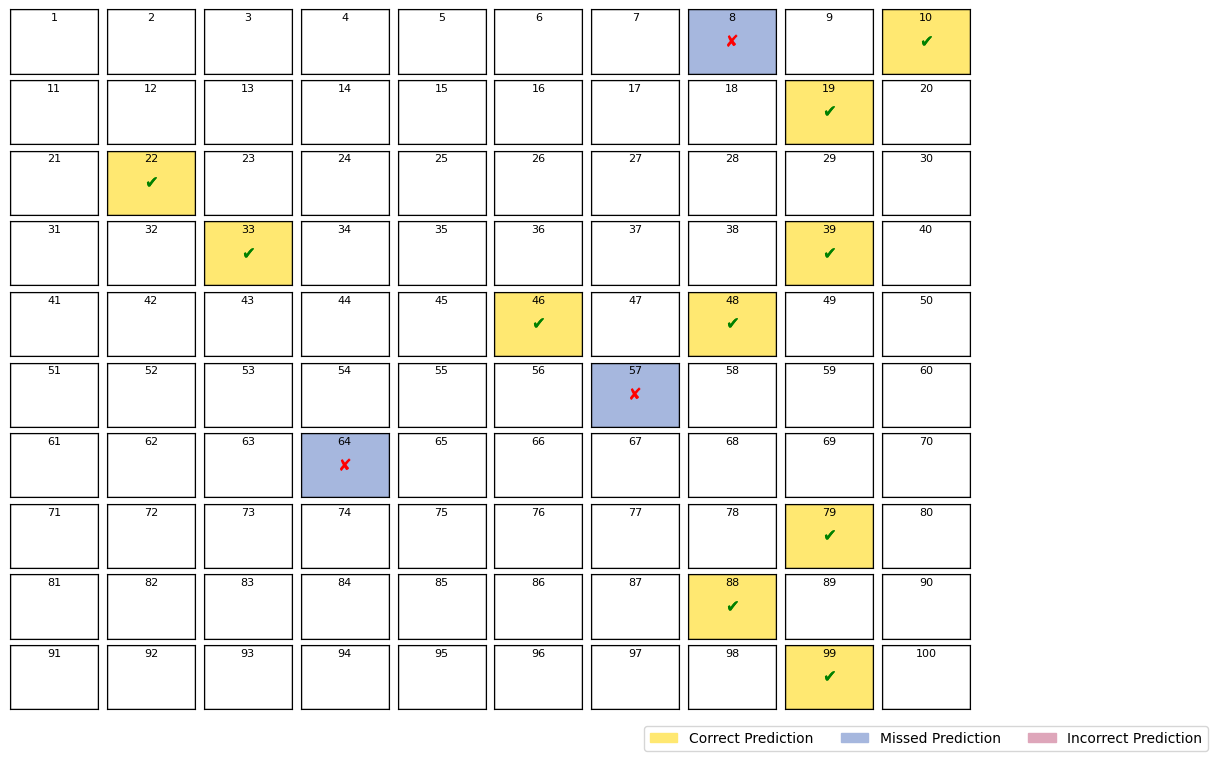

In [35]:
represent_pages(df, narrator)

# Analysis

Applying binary classification to all narrators reveals a compelling finding: Bill Hardy is the only narrator who can be reliably identified, confirming the observation of the multiclass classification results.

Consequently, pages belonging to Bill Hardy have characteristics that distinguish them from other narrators—from the model perspective.

_(TODO: to complete)_